# CFU herds - are they different to neighbours?

* look at CFU/feedlot herds to assess if the strains detected in these herds are similar to other strains found locally (suggesting local transmission) or similar to strains local to herds the animals previously resided in (detection associated with movement)

```class	sub_class	Description
B	BP	Beef Pedigree
B	BSB	Beef Suckler to Beef (ie to slaughter)
B	BSW	Beef Suckler to Weanling
B	BSY	Beef Suckler to Youngstock
B	BSY_nR	Beef Suckler to Youngstock non-rearing
D	D	Standard Dairy
D	DnR_C	Dairy non-rearing using contract rearing
D	DnR_nC	Dairy non-rearing - not using contract rearing
D	DRm	Dairy rearing, including males
F	F	Fattening
M	M	Mixed type
S	Rdf	Rearing dairy females
S	Sbf	Stores - beef females
S	Sbm	Stores - beef males
S	Sbmx	Stores - beef, mixed sex
S	Sdm	Stores - dairy for slaughter [not sure what the 'm' stands for]
T	T	Trading
U	U	Unknown - all herds with some activity in the year but which did not have animals in it in both May and September
```

In [1]:
import sys,os,io,shutil,subprocess
import glob, time
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import geopandas as gpd

from tracebtb import tools, core, plotting
from matplotlib_scalebar.scalebar import ScaleBar
sns.set_context('notebook',font_scale=1.4)

In [15]:
final = pd.read_csv('/storage/btbgenie/all_ireland_results/metadata.csv')
moves = pd.read_csv('/storage/btbgenie/monaghan/metadata/movement/primary_moves.csv')
snpdist = pd.read_csv('/storage/btbgenie/all_ireland_results/snpdist.csv',index_col=0)
hs = pd.read_csv('herd_summary.csv')
counties = gpd.read_file('metadata/counties.shp')
counties = counties.to_crs("EPSG:29902")
gdf = gpd.GeoDataFrame(final,geometry=gpd.points_from_xy(final.X_COORD,final.Y_COORD)).set_crs('EPSG:29902')
gdf['color'],cmap = plotting.get_color_mapping(gdf, 'short_name', seed=25)
gdf = gdf[~gdf.geometry.is_empty]

In [3]:
lpis = gpd.read_file('LPIS/lpis_combined.shp').set_crs('EPSG:29902')
lpis_cent = gpd.read_file('LPIS/lpis_cent.shp').set_crs('EPSG:29902')

## get metric of long range or local moves for all herds

<Axes: >

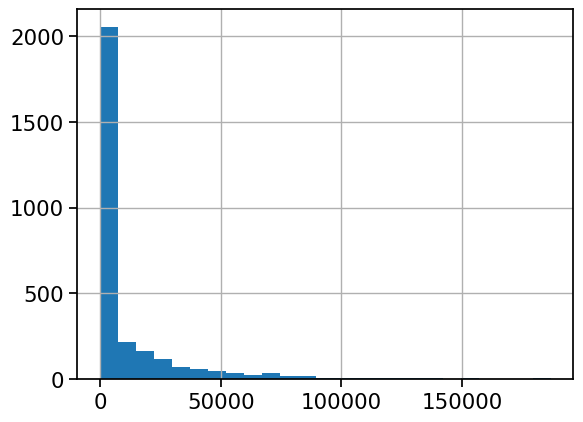

In [41]:
def get_move_ranges(df):
    df_moves = tools.get_moves_bytag(df, moves, lpis_cent)
    if df_moves is None:
        return
    point = df.iloc[0].geometry  
    return df_moves.geometry.distance(point).dropna().mean()
    
def apply_move_ranges(x):
    df = gdf[gdf.HERD_NO==x.herd]
    if len(df)==0:
        return 
    return get_move_ranges(df)
    
hs['median_move_dist'] = hs.apply(apply_move_ranges,1) 
hs.median_move_dist.hist(bins=25)

In [42]:
feedlot=pd.read_csv('/storage/btbgenie/monaghan/metadata/feedlots.csv')
hs['HERD_NO']=hs.herd
hsf = hs[hs.herd.isin(feedlot.herd_no)]
hs['CFU'] = hs.herd.isin(feedlot.herd_no)
hsf=hs[hs.CFU==True]
#hsf=hs[hs.herd_class.isin(['T','F'])]
hso=hs[~hs.herd_class.isin(['T','F'])]
len(hsf),len(hso)

(148, 2896)

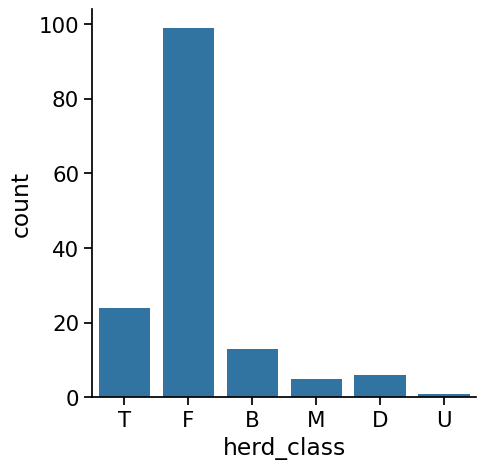

In [18]:
#feedlot[feedlot.herd_no.isin(final.HERD_NO)]
cg=sns.catplot(hsf,kind='count',x='herd_class',aspect=1)

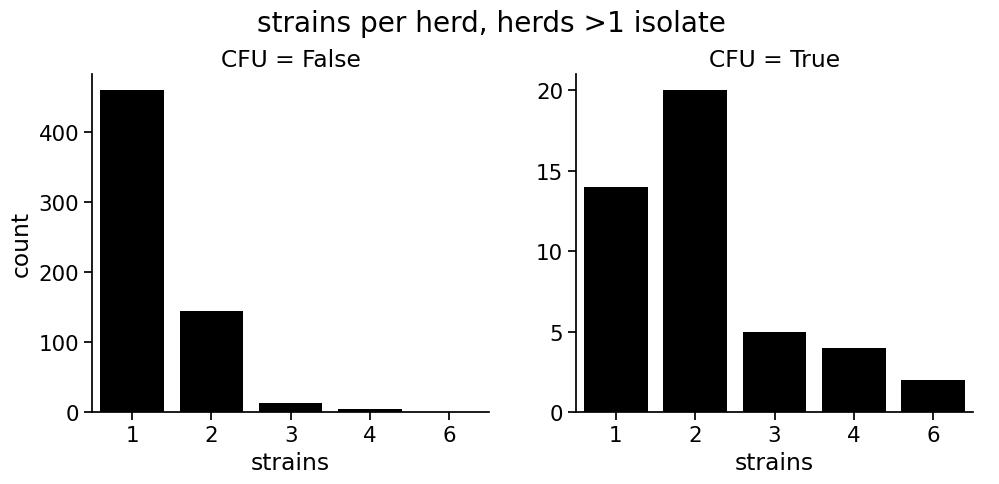

In [30]:
hsm = hs[hs.isolates>1]
cg=sns.catplot(hsm,x='strains',kind='count',col='CFU',color='black',aspect=1,sharey=False)#,stat='proportion')
cg.fig.subplots_adjust(top=0.85)
cg.fig.suptitle('strains per herd, herds >1 isolate')
cg.fig.savefig('strains_per_herd.png',dpi=200)

In [ ]:
fl = gdf[gdf.HERD_NO.isin(hsf.herd)]
print (len(fl))
ax=counties.plot(color='none',lw=.1,figsize=(8,8))
plotting.plot_grid(grid, mask, cmap='coolwarm',ax=ax)

In [21]:
countgrid = gpd.read_file('homeranges.shp')

## inward moves from any farm

* get inward moves from any farm 
* correlate with local strains in source farm - requires 2 step filter to get the animals move history - very hard too many moves in?
* include marts and the local strains where they are - also mad

In [32]:
import polars as pl
from tracebtb import movement
movement.BASEFILE = '/storage/btbgenie/monaghan/metadata/movement/cattle_moves_2023_cleaned.csv'
default_query = movement.get_default_query()

In [34]:
herds = list(hs.herd.dropna())
print (len(herds))
q = default_query.filter((pl.col("herd").is_in(herds)))
st=time.time()
f = q.collect(streaming=True)
#print (q.explain(streaming=True))
t = time.time()-st
print (t)
print (f)

3388
180.4849750995636
shape: (7_293_843, 12)
┌───────────┬───────────────┬──────────┬────────────┬───┬────────────┬───────────┬──────────┬──────┐
│ id        ┆ tag           ┆ herd     ┆ event_date ┆ … ┆ event_type ┆ rnk_final ┆ rnk_desc ┆ year │
│ ---       ┆ ---           ┆ ---      ┆ ---        ┆   ┆ ---        ┆ ---       ┆ ---      ┆ ---  │
│ i64       ┆ str           ┆ str      ┆ date       ┆   ┆ str        ┆ i64       ┆ i64      ┆ i32  │
╞═══════════╪═══════════════╪══════════╪════════════╪═══╪════════════╪═══════════╪══════════╪══════╡
│ 125590001 ┆ 3722121051409 ┆ Y1751210 ┆ 2020-10-10 ┆ … ┆ m          ┆ 202003    ┆ 2        ┆ 2020 │
│           ┆ 93            ┆          ┆            ┆   ┆            ┆           ┆          ┆      │
│ 125590216 ┆ 3722121052602 ┆ Q1041208 ┆ 2019-07-11 ┆ … ┆ m          ┆ 201903    ┆ 3        ┆ 2019 │
│           ┆ 10            ┆          ┆            ┆   ┆            ┆           ┆          ┆      │
│ 125590476 ┆ 3722121053310 ┆ O107102X ┆ 2019

In [35]:
f = f.filter(pl.col("year") >= 2012)
#f.write_csv("herd_inward_moves.csv")

In [36]:
moves_in = pd.read_csv('herd_inward_moves.csv')
moves_in = moves_in[moves_in.data_type=="F_to_F"]

/tmp/ipykernel_1078417/2010419448.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  moves_in = pd.read_csv('herd_inward_moves.csv')


In [ ]:
m = moves_in[moves_in.data_type=="F_to_F"]
m=m[m.herd=='Q1310560']
m=m.sort_values(by=["event_date"], ascending=True)
m

## neighbouring strains analysis

In [38]:
def get_circle(point, radius):
    # Calculate the centroid of all points
    #centroid = gdf.geometry.unary_union.centroid    
    # Create a circle (buffer) around the centroid with the specified radius
    circle = point.buffer(radius)    
    circle_gdf = gpd.GeoDataFrame({'geometry': [circle], 'color': ['red']}, crs=gdf.crs)
    return circle_gdf

### risk metrics

* herd_class: class of herd, (beef, dairy, fattening)
* fragments: land fragments
* moves_in: no of moves into herd in last n years.
* median_moves_dist: media distance of moves in to herd
* isolates: no of isolates in herd (animals sampled)
* herd_strains: strains in herd
* neighbours: no. of neighbouring herds
* nb_str: no of unique strains in neighbourhood
* shared_str: no of shared strains
* shared: has shared strains with neighbours yes/no


total herds: 2, no neighbours:0


/tmp/ipykernel_1078417/1278788999.py:53: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  nb[nb.Species=='Badger'].plot(color=nb.color,marker='s',markersize=60,ax=ax)


,herd,herd_class,fragments,moves_in,median_moves_dist,isolates,herd_strains,neighbours,nb_str,shared_samples,shared_str,shared
0,R1201429,F,4,582,14.308390,2,2,3,3,0,0,False
1,O1180083,F,5,22,16.795173,3,1,34,7,6,1,True


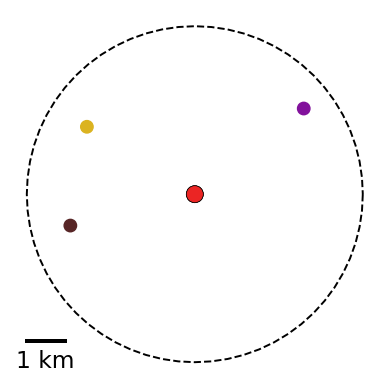

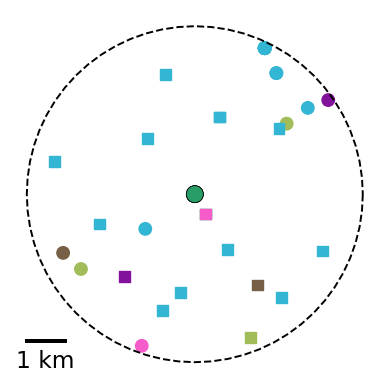

In [43]:
reload(tools)

def herd_risk_metrics(hs,gdf,dist=4000,plot=False):
    """Check risk metrics like neighbouring strains against a df of herds"""
    
    col='short_name'
    res=[]
    nn = 0    
    for i,r in hs.iterrows():
        #print (r)        
        #print (r.HERD_NO,r.isolates)  
        #print ('---------------')
        sub = gdf[gdf.HERD_NO==r.HERD_NO]
        if len(sub)==0: 
            continue
        point = sub.iloc[0].geometry       
        nb = tools.find_points_within_distance(gdf, point, dist) 
        nb = nb[nb.HERD_NO!=r.HERD_NO]
        #exclude neighbour strains not in their home ranges?       
        nb = nb[(nb.in_homerange==True) | (nb.Species=='Badger')]
       
        if len(nb)<=1:
            #print ('no neighbours')
            nn+=1
            continue
        #print(f'{len(nb)} neighbours with samples')
        found = nb[nb[col].isin(sub[col])]
        target_str = sub[col].value_counts()
        nb_str = nb[col].value_counts()
        
        #get parcels and check fragments?
        pcl = lpis[lpis.SPH_HERD_N==r.HERD_NO].copy()
        if len(pcl)==0:
            fragments = None
        else:
            try:
                fragments = len(pcl.iloc[0].geometry.geoms)
            except:
                fragments = 1

        #add years for samples in CFU        
        years = sub.Year.value_counts()        
        ## no of inward moves in last N years
        mv = moves_in[moves_in.herd==r.HERD_NO]

        #moves for neighbours - local or long range?       
        #nb_move_dist = get_move_ranges(nb)
        
        if plot==True:
            ax=sub.plot(color=sub.color,markersize=150,lw=.5,ec='black')
            #gr.plot(column='name',ec='black',alpha=0.2,legend=True,ax=ax)            
            nb[nb.Species=='Bovine'].plot(color=nb.color,markersize=80,ax=ax)
            nb[nb.Species=='Badger'].plot(color=nb.color,marker='s',markersize=60,ax=ax)
            #pcl.plot(color='none',ax=ax)
            #ax.set_title(r.HERD_NO)
            ax.set_facecolor('gray')
            ax.axis('off')   
            ax.add_artist(ScaleBar(dx=1, location=3))                  
            circ = get_circle(point, dist)
            circ.plot(color='none',lw=1.4,ls='--',ax=ax)
            
        #print (nb_str)
        shared_str = nb_str[nb_str.index.isin(target_str.index)]
        #print (shared_str)
        has_shared = any(x > 0 for x in shared_str)        
        res.append([r.HERD_NO,r.herd_class,fragments,len(mv),r.median_move_dist/1000,r.isolates,len(sub[col].unique()),len(nb),len(nb_str),len(found),len(shared_str),has_shared])
       
    res=pd.DataFrame(res,columns=['herd','herd_class','fragments','moves_in','median_moves_dist','isolates','herd_strains','neighbours','nb_str','shared_samples','shared_str','shared'])
    print (f'total herds: {len(hs)}, no neighbours:{nn}')
    return res

testherds=['O1180083','R1201429']
res = herd_risk_metrics(hsf[hsf.herd.isin(testherds)],gdf,dist=4000,plot=True)
#res = herd_risk_metrics(hsf.sample(5),gdf,dist=4000,plot=True)
res

In [ ]:
res2 = herd_risk_metrics(hso.sample(20),gdf,dist=5000)
s2=res2.shared_str.value_counts().sort_index()
res2

## run over range of thresholds

In [44]:
dists=range(1000,13000,1000)
ratios=[]
hsmnocfu = hsm[hsm.CFU==False]
for d in dists:    
    print (d)
    df1 = herd_risk_metrics(hsf,gdf,dist=d)
    s1=df1.shared.value_counts().sort_index()
    r1 = s1.loc[True] / s1.sum()
    df2 = herd_risk_metrics(hso,gdf,dist=d)
    s2=df2.shared.value_counts().sort_index()
    r2 = s2.loc[True] / s2.sum()    
    #multi strain herds non CFU
    #df3 = herd_risk_metrics(hsmnocfu,gdf,dist=d)
    #s3=df3.shared.value_counts().sort_index()
    #r3 = s3.loc[True] / s3.sum()      
    x=[d,r1,r2]
    for c in ['B','D','F']:
        h=hs[hs.herd_class==c]        
        df = herd_risk_metrics(h,gdf,dist=d)
        s=df.shared.value_counts().sort_index() 
        r = s.loc[True] / s.sum()
        x.append(r)
    print (x)
    ratios.append(x)
ratios = pd.DataFrame(ratios,columns=['dist','CFU','all non-CFU','Beef','Dairy','Fattening'])

1000
total herds: 148, no neighbours:128
total herds: 2896, no neighbours:2574
total herds: 1192, no neighbours:1102
total herds: 796, no neighbours:724
total herds: 450, no neighbours:406
[1000, 0.375, 0.7066666666666667, 0.7023809523809523, 0.5942028985507246, 0.6363636363636364]
2000
total herds: 148, no neighbours:114
total herds: 2896, no neighbours:2022
total herds: 1192, no neighbours:932
total herds: 796, no neighbours:562
total herds: 450, no neighbours:327
[2000, 0.4090909090909091, 0.7112676056338029, 0.6929133858267716, 0.670995670995671, 0.5714285714285714]
3000
total herds: 148, no neighbours:94
total herds: 2896, no neighbours:1489
total herds: 1192, no neighbours:714
total herds: 796, no neighbours:406
total herds: 450, no neighbours:250
[3000, 0.38095238095238093, 0.6714801444043321, 0.6377118644067796, 0.6149870801033591, 0.5396825396825397]
4000
total herds: 148, no neighbours:76
total herds: 2896, no neighbours:1100
total herds: 1192, no neighbours:552
total herds: 

Text(0.5, 0, 'radius')

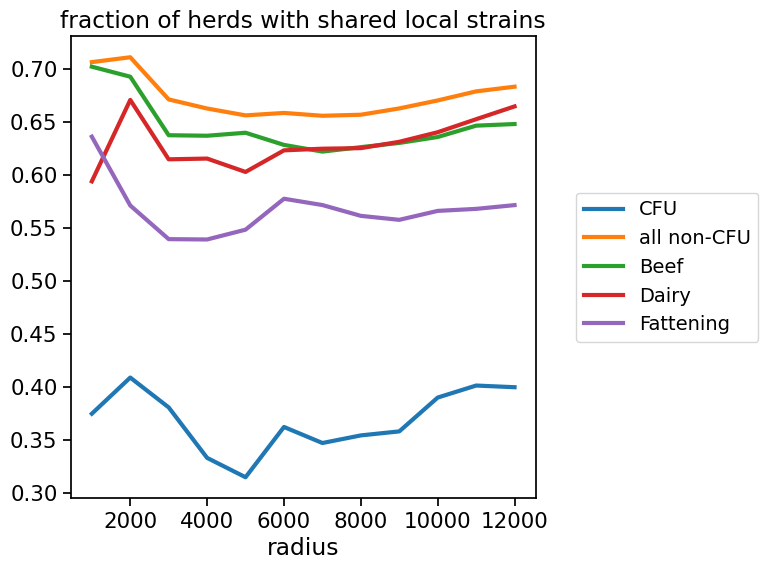

In [45]:
ax=ratios.plot(x='dist',lw=3,figsize=(6,6))
ax.legend(fontsize=14,loc=5, bbox_to_anchor=(1.5, 0.5))
ax.set_title('fraction of herds with shared local strains')
ax.set_xlabel('radius')

## statistical test for CFU association with strain sharing

In [46]:
def get_ratios(h1,h2,dist=5000):
    res1 = herd_risk_metrics(h1,gdf,dist=dist)
    res2 = herd_risk_metrics(h2,gdf,dist=dist)
    s1=res1.shared.value_counts().sort_index()
    s2=res2.shared.value_counts().sort_index()
    r1 = s1.loc[True] / s1.sum()
    r2 = s2.loc[True] / s2.sum()
    #print (r1,r2)
    return s1,s2
s1,s2=get_ratios(hsf,hso)#[hso.isolates>1])

total herds: 148, no neighbours:63
total herds: 2896, no neighbours:822


In [47]:
s1,s2

(shared
 False    50
 True     23
 Name: count, dtype: int64,
 shared
 False     705
 True     1347
 Name: count, dtype: int64)

In [48]:
cont=pd.DataFrame({'not shared':[s1.loc[False],s2.loc[False]],'shared':[s1.loc[True],s2.loc[True]]})
cont.index=['CFU','non-CFU']
cont.loc['total']=cont.sum()
cont

,not shared,shared
CFU,50,23
non-CFU,705,1347
total,755,1370


In [49]:
cfu_notshared = s1.loc[False]
cfu_shared = s1.loc[True]
other_notshared = s2.loc[False]
other_shared = s2.loc[True]

# Create a contingency table
contingency_table = [
    [cfu_shared, cfu_notshared],
    [other_shared, other_notshared]
]
print (contingency_table)
import scipy.stats as stats
# Perform Fisher's Exact Test
odds_ratio, p_value = stats.fisher_exact(contingency_table)
print(f"Fisher's Exact Test odds ratio: {odds_ratio} p-value: {p_value:.6f}")


[[23, 50], [1347, 705]]
Fisher's Exact Test odds ratio: 0.24075723830734966 p-value: 0.000000


## logistic regression models

In [52]:
res = herd_risk_metrics(hsf,gdf,dist=5000)
res2 = herd_risk_metrics(hso,gdf,dist=5000)

total herds: 148, no neighbours:63
total herds: 2896, no neighbours:822


In [53]:
print (res2.sample(5))

          herd herd_class  fragments  moves_in  median_moves_dist  isolates  herd_strains  neighbours  nb_str  shared_samples  shared_str  shared
703   Z2071088          B        6.0        98           0.240973         1             1           2       2               1           1    True
1269   2298102        NaN        NaN         0                NaN         1             1           3       1               3           1    True
1450   6145407        NaN        NaN         0                NaN         1             1           2       2               1           1    True
2013  G231082X          B        8.0        34           0.033288         1             1           7       1               0           0   False
1895  D2940516          D        6.0       111          25.537527         3             1          45       8              21           1    True


In [61]:
res['CFU']=True
res2['CFU']=False
allres = pd.concat([res,res2]).dropna()
allres['CFU'] = allres['CFU'].astype(int)
allres['shared'] = allres['shared'].astype(int)
allres['herd_class'] =  pd.Categorical(allres.herd_class).codes
allres['multi_strain'] = (allres.herd_strains>1).astype(int)
multi_isolates_res = allres[allres.isolates>1].copy()
len(res),len(res2),len(multi_isolates_res)
multi_isolates_res.to_csv('herd_risk_metrics.csv')

In [62]:
multi_isolates_res.herd_strains.value_counts()

herd_strains
1    280
2    104
3     13
4      4
6      2
Name: count, dtype: int64

## fit against herd no. of strains - risks for multi strain farms

This lead us to investigate if any particular features of these herds determine a higher risk of having multiple strains. To do this we calculated a set of potentially relevant herd-level risk metrics (detailed in methods) and fitted a logistic regression model with ‘multi-strains’ as the dependent variable (a binary value True if the herd had >1 strain). We also added the number of isolates per herd as a covariate to account for the sampling bias. (Herds with only one isolate sampled cannot have more than one strain). The model showed a significant positive association between CFU status (p<0.001) and number of isolates sampled. Other variables did not show significant associations. 

In [56]:
import statsmodels.api as sm

df = allres
#df = multi_isolates_res

X = df[['CFU','herd_class','fragments','neighbours','nb_str','median_moves_dist','moves_in','isolates']]
#y = df['herd_strains']
y = df['multi_strain']
X = sm.add_constant(X)

model = sm.Logit(y, X)
#model = sm.GLM(y, X,family=sm.families.Poisson(),
#              offset=np.log(df['isolates'])) 

result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.210892
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           multi_strain   No. Observations:                 1733
Model:                          Logit   Df Residuals:                     1724
Method:                           MLE   Df Model:                            8
Date:                Sat, 21 Jun 2025   Pseudo R-squ.:                  0.1767
Time:                        20:19:53   Log-Likelihood:                -365.48
converged:                       True   LL-Null:                       -443.92
Covariance Type:            nonrobust   LLR p-value:                 7.185e-30
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -4.6806      0.296    -15.830      0.000      -5.260      -4.101
CFU     

## fit against shared status - shows CFU effect

In [90]:
import statsmodels.api as sm

df = allres
#df = multi_isolates_res
#print (df[:2])
df["CFUxmoves_in"] = df.CFU * df.moves_in
X = df[['CFU','moves_in','herd_class','fragments','herd_strains','nb_str','neighbours','isolates']]
y = df['shared']
X = sm.add_constant(X)

#standarize?
'''from sklearn.preprocessing import StandardScaler
# Standardize predictors (Z-score transformation)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=df.index,columns=X.columns)
X_scaled = sm.add_constant(X_scaled)'''

model = sm.Logit(y, X)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.618240
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 shared   No. Observations:                 1733
Model:                          Logit   Df Residuals:                     1724
Method:                           MLE   Df Model:                            8
Date:                Mon, 23 Jun 2025   Pseudo R-squ.:                 0.07628
Time:                        12:32:02   Log-Likelihood:                -1071.4
converged:                       True   LL-Null:                       -1159.9
Covariance Type:            nonrobust   LLR p-value:                 4.485e-34
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.9971      0.240     -4.155      0.000      -1.467      -0.527
CFU             -1.2023

<Axes: xlabel='shared', ylabel='moves_in'>

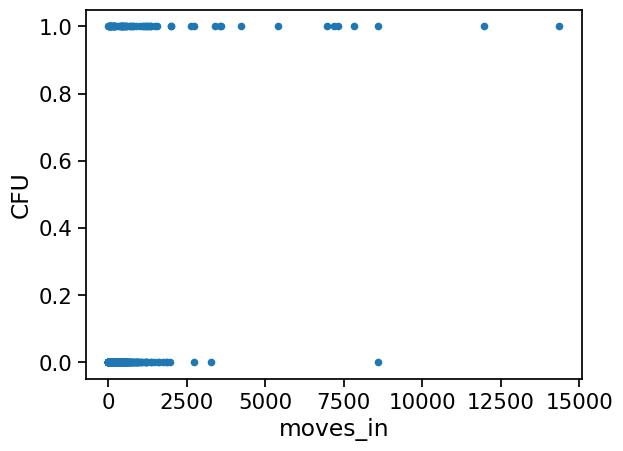

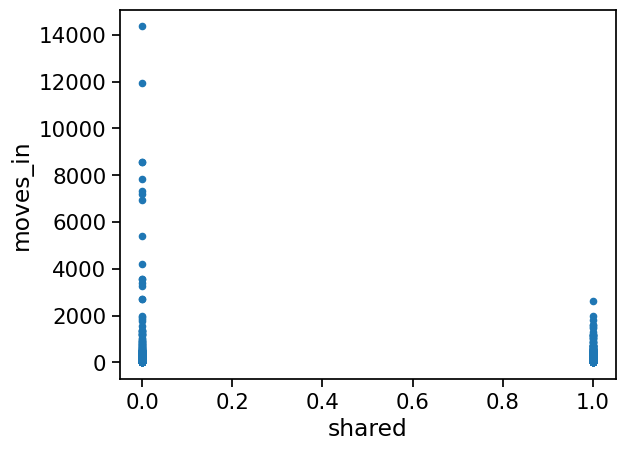

In [94]:
df.plot('moves_in','CFU',kind='scatter')
df.plot('shared','moves_in',kind='scatter')
#sns.lmplot(data=df, x="moves_in", y="shared", hue="CFU", logistic=True)

In [69]:
from scipy.stats import pointbiserialr

correlation, p_value = pointbiserialr(df['CFU'], df['moves_in'])
print(f"Point Biserial Correlation: {correlation}, p-value: {p_value}")

Point Biserial Correlation: -0.0024158313214739323, p-value: 0.9199497727645984


## Coefficients from the model

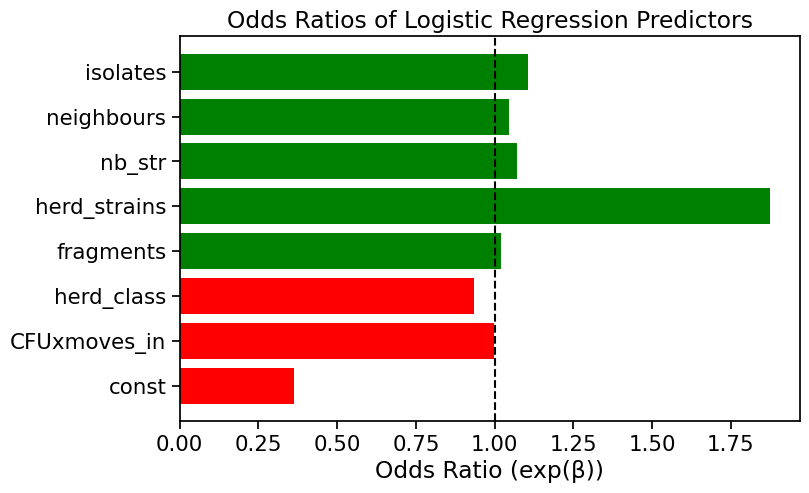

In [89]:
coef = result.params.tolist()
features = result.params.index.tolist()
odds_ratios = np.exp(coef)
# Plot
plt.figure(figsize=(8, 5))
plt.barh(features, odds_ratios, color=['red' if or_ < 1 else 'green' for or_ in odds_ratios])
plt.axvline(x=1, color='black', linestyle='--')  # Reference line at OR=1
plt.xlabel("Odds Ratio (exp(β))")
plt.title("Odds Ratios of Logistic Regression Predictors")
plt.show()

In [852]:
result.pred_table()

array([[ 61., 427.],
       [ 43., 760.]])

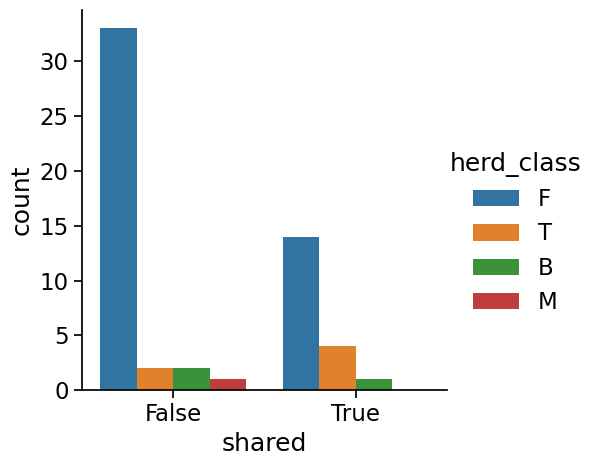

In [841]:
cg=sns.catplot(res,x='shared',kind='count',hue='herd_class',aspect=1,sharey=False)

Text(0.5, 1.0, 'strain sharing vs. median moves distance\n of sampled animals by CFU status')

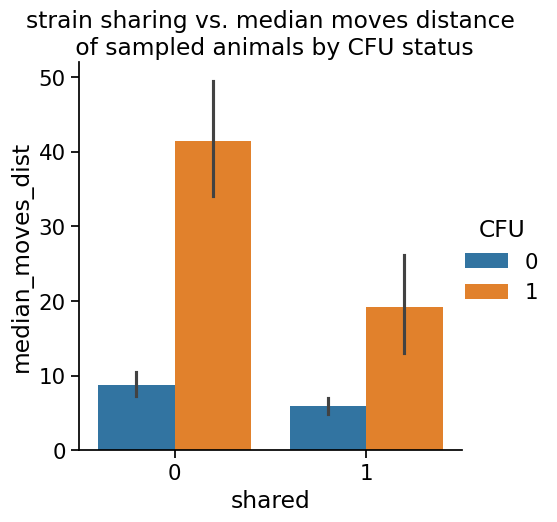

In [64]:
cg=sns.catplot(allres,x='shared',y='median_moves_dist',kind='bar',hue='CFU',aspect=1,sharey=False)
plt.title('strain sharing vs. median moves distance\n of sampled animals by CFU status')

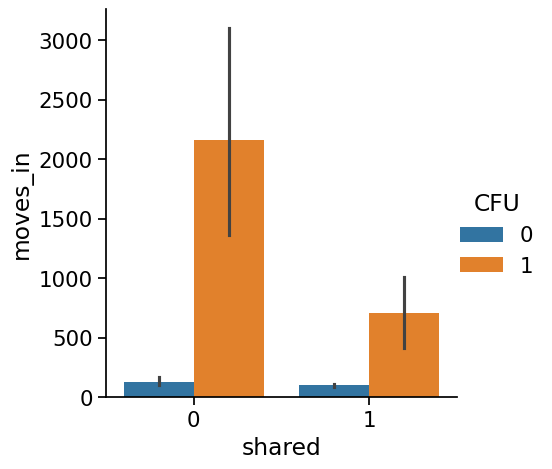

In [79]:
cg=sns.catplot(allres,x='shared',y='moves_in',kind='bar',hue='CFU',aspect=1,sharey=False)

In [ ]:
mapping = res.set_index('herd')['shared']
x=gdf.merge(res,left_on='HERD_NO',right_on='herd',how='inner')
ax=x.plot(column='shared',legend=True,figsize=(7,7))
ax.axis('off')

## sklearn model

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Encode categorical variable
#data = pd.get_dummies(df, columns=['herd_class'], drop_first=True)
X = df[['CFU','fragments','herd_strains','nb_str','neighbours','isolates','moves_in']]
y = df['shared']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Choose a model (Logistic Regression or Random Forest)
model = make_pipeline(StandardScaler(), LogisticRegression())  # or RandomForestClassifier()

# Train model
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.21      0.31        78
           1       0.58      0.90      0.70        96

    accuracy                           0.59       174
   macro avg       0.60      0.55      0.51       174
weighted avg       0.60      0.59      0.53       174



In [73]:
from sklearn.linear_model import LogisticRegression

# Train the logistic regression model
model = LogisticRegression(max_iter=1000,penalty='l2')
model.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0],
    'Abs_Coefficient': np.abs(model.coef_[0])
})

# Sort by absolute importance
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)
print(feature_importance)


        Feature  Coefficient  Abs_Coefficient
0           CFU    -1.046021         1.046021
2  herd_strains     0.625242         0.625242
5      isolates     0.102541         0.102541
3        nb_str     0.069531         0.069531
4    neighbours     0.044659         0.044659
1     fragments     0.025177         0.025177
6      moves_in    -0.000553         0.000553


In [77]:
from sklearn.feature_selection import RFE
# Use Logistic Regression for RFE
log_reg = LogisticRegression(max_iter=1000)
rfe = RFE(log_reg, n_features_to_select=5)  # Select top 5 features
rfe.fit(X, y)

# Show selected features
selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)

Selected Features: Index(['CFU', 'fragments', 'herd_strains', 'neighbours', 'isolates'], dtype='object')


In [78]:
# Train a Random Forest model
rf = RandomForestClassifier(random_state=12)
rf.fit(X, y)

# Get feature importance
feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_importance)


moves_in        0.306697
neighbours      0.265032
fragments       0.167380
nb_str          0.104669
isolates        0.092878
herd_strains    0.040330
CFU             0.023014
dtype: float64
